In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt  
import seaborn as sns

In [2]:
# PLotting line graph
def plot_(x,y,x_l,y_l,t):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(dpi = 150)
    ax = plt.axes() 
    plt.plot(x, y, color = 'red')
    plt.title(t)
    plt.xlabel(x_l)
    plt.ylabel(y_l) 

# Regression part

## Feature Engineering, selection and Splitting the data

In [3]:
# Reading the csv
df = pd.read_csv('1.csv')  

# Dropping features that have a correlation of  < 0.2 with motor_speed or high correlation between them
df = df.drop(['coolant','i_q', 'profile_id', 'torque', 'ambient', 'stator_tooth', 'stator_yoke', 'pm', 'u_d'], axis = 1) 


In [4]:
# Splitting the  X and target column
X=df.drop("motor_speed", axis=1) 
y=df["motor_speed"]  

# Reducing the 133k dataset to 10k. 
new_df = pd.concat([X,y], axis =1).sample(frac=1)
X, y = new_df.iloc[:50000,:-1],  new_df.iloc[:50000,-1]

# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)


# Evaluating KNN Regressor params

In [5]:
from sklearn.neighbors import KNeighborsRegressor   
from sklearn.metrics import mean_squared_error 

n_neigh = list() 
MSE_list = list()
for i in range(1,22,2):
    n_neigh.append(i)  
    
    
for neigh in n_neigh:  
    knn_model=KNeighborsRegressor( n_neighbors = neigh ).fit(X_train, y_train)
    y_pred=knn_model.predict(X_test)  
    MSE_list.append( mean_squared_error(y_pred,y_test) )

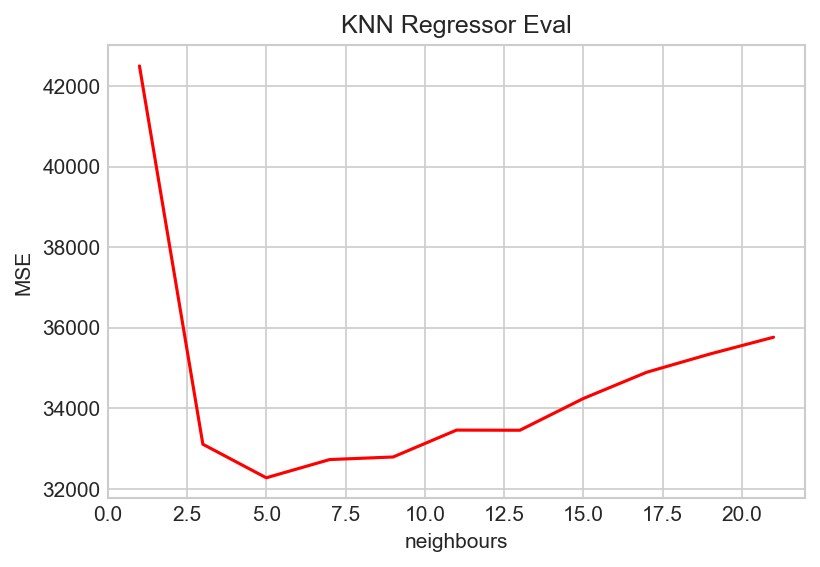

In [6]:
plot_( n_neigh, MSE_list, 'neighbours', 'MSE', 'KNN Regressor Eval' )

### A stable and minimum MSE was obtained at 5 neighbours param.  Then it overfits.

# DecisionTreeRegressor Heatmap

In [7]:
from sklearn.tree import DecisionTreeRegressor  
from sklearn.metrics import mean_squared_error   


def  DTR(criterion_): 
    # Definind max_feature values (actually till len(X.columns) )
    feat = [1,2,3] 
    # Defining max_depth values
    dep = [3, 7,12,15,20,30]  
    # Creating an empty matrix
    a = np.empty([len(feat),len(dep)])  

    # Training the model and storing the MSE in the matrix
    for i in range(len(feat)):
        for j in range(len(dep)):
            regressor = DecisionTreeRegressor(random_state = 0, max_depth = dep[j] , max_features = feat[i], criterion = criterion_ )             
            regressor.fit(X_train, y_train)  
            y_pred = regressor.predict(X_test)   
            a[i][j]  = mean_squared_error(y_pred,y_test)  
            
    # Plotting the heatmap
    ax = sns.heatmap(a, annot=True, xticklabels=dep,   yticklabels= feat)  

###### Friedman_MSE criterion

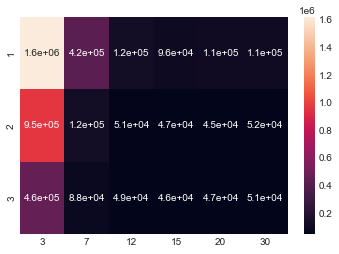

In [8]:
DTR('friedman_mse')

### As expected, the more we increase the max_depth, it is more accurate.  
### We can actually observe the  overfit on all 3 features after 20 max_depth. 

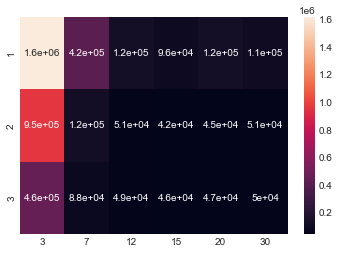

In [9]:
DTR('squared_error')

### I could not use 'poison' because some target values are negative. Tried to scale them but the density is around +/-0.0 and it returns 0 values. 
### About the squared_error, it is almost the same as friedman_mse, a bit worse. 0.1 precision

# RandomForestRegressor : Line plot

### It does not have the 'gini' and 'entropy' criterions, so I just plotted the estimators

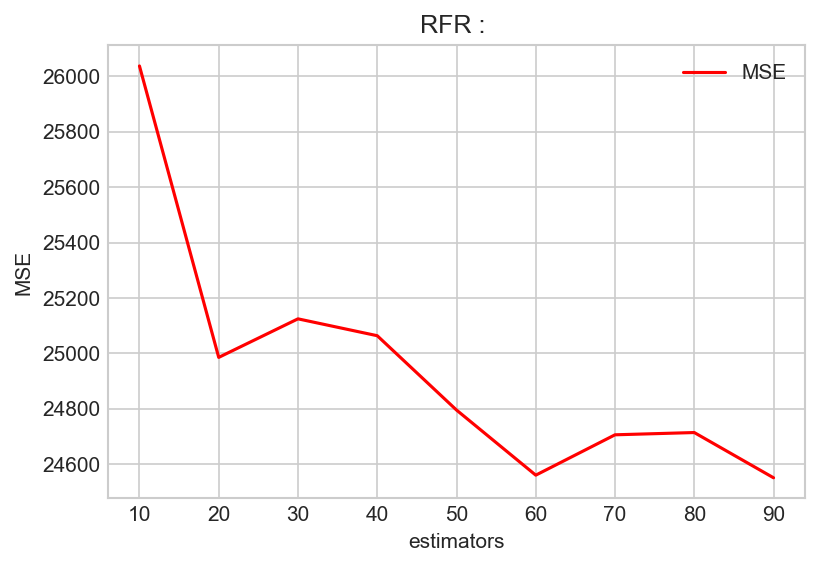

In [10]:
from  sklearn.ensemble import RandomForestRegressor 
# generating estimators
n_est = list()
for i in range(10,100,10):
    n_est.append(i)  

# 

MSE_list = list()
for i in range(len(n_est)):
        regressor = RandomForestRegressor(random_state = 42, criterion = 'squared_error', n_estimators = n_est[i] )
        regressor.fit(X_train, y_train)  
        y_pred = regressor.predict(X_test)   
        MSE_list.append ( mean_squared_error(y_pred,y_test) )  

plt.style.use('seaborn-whitegrid')
fig = plt.figure(dpi = 150)
ax = plt.axes() 
plt.plot(n_est, MSE_list, color = 'red', label = 'MSE' ) 
plt.title('RFR : ')
plt.xlabel('estimators')
plt.ylabel('MSE') 
plt.legend()
        

### 60 is good, after the model overfits ( tested on 113k dataset, here is 50k)

# SVR

In [11]:
from sklearn.svm import SVR

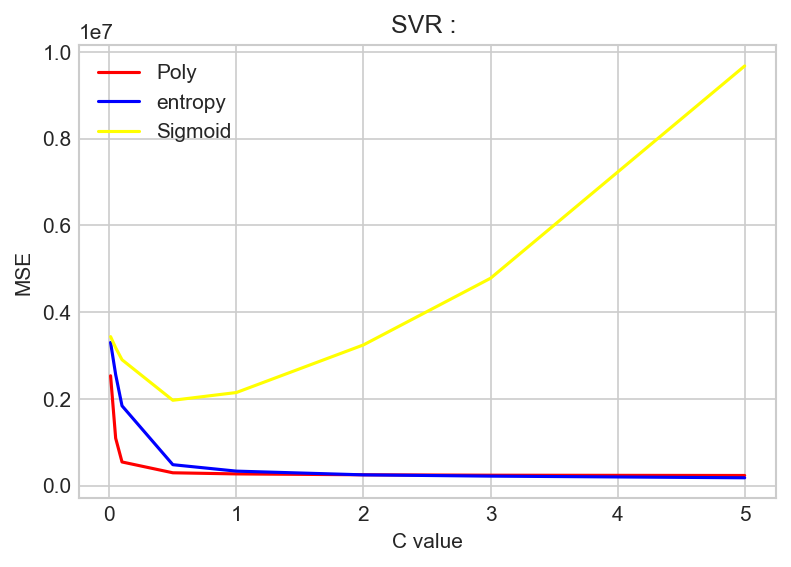

In [12]:
# Declaring necessary lists
C_list = [ 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 3.0,5.0 ]


ker_list = ['poly', 'rbf', 'sigmoid'] 
final_mse = list()

# For each kernel type
for ker in ker_list:
    
    # Adds the MSE Array
    MSE_list = list() 
    
    # for different C values
    for i in range(len(C_list)):
            regressor = SVR(kernel = ker, C = C_list[i] )
            regressor.fit(X_train, y_train)  
            y_pred = regressor.predict(X_test)   
            MSE_list.append ( mean_squared_error(y_pred,y_test) )  
            
    final_mse.append(MSE_list) 

plt.style.use('seaborn-whitegrid')
fig = plt.figure(dpi = 150)
ax = plt.axes() 
plt.plot(C_list, final_mse[0], color = 'red', label = 'Poly' ) 
plt.plot(C_list, final_mse[1], color = 'blue', label = 'entropy') 
plt.plot(C_list, final_mse[2], color = 'yellow', label = 'Sigmoid')
plt.title('SVR : ')
plt.xlabel('C value')
plt.ylabel('MSE') 
plt.legend()

# Would go for polynomial  and entropy kernels as  the optimal kernels and a C of 1.0 for entropy and 0.05 for the Poly. 
#  For the sigmoid kernel, the bigger C, the bigger regularization and smaller bias, directs the model to the underfitting direction as MSE increases again

#  Classification

In [13]:
# Reading, concatening the train and test samples and removing specific categorical features.
X =  pd.concat( [ pd.read_csv("X_train.csv") , pd.read_csv("X_test.csv")], axis = 0 ).drop(['CustomerId','Surname','Geography'],axis =1)
y =  pd.concat( [ pd.read_csv("y_train.csv") , pd.read_csv("y_test.csv")], axis = 0).drop('CustomerId',axis =1)

# Replacing the gender feature with numerical value
X['Gender'] = X['Gender'].map({'Female':1, 'Male': 0,' male' : 0, 'female': 1})  

# pd.concat([X,y],axis =1).corr()  
# Choosing the correlation > 0.1 or higher corr between them 
X = X.drop(['CreditScore', 'Tenure', 'HasCrCard', 'NumOfProducts', 'EstimatedSalary'],axis =1)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# KNN Evaluation

In [15]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import  accuracy_score 

# Initinalizing the neighbour and accuracy score list
n_neigh = list()  
acc_list = list()  

# generating the numbers of neighbours
for i in range(1,22,2):
    n_neigh.append(i)  
    

for neigh in n_neigh:
    classifier = KNeighborsClassifier(n_neighbors = neigh, metric = 'minkowski', p = 2)
    classifier.fit(X_train, y_train.values.ravel() ) 
    acc_list.append ( accuracy_score(y_test, classifier.predict(X_test) ) ) 

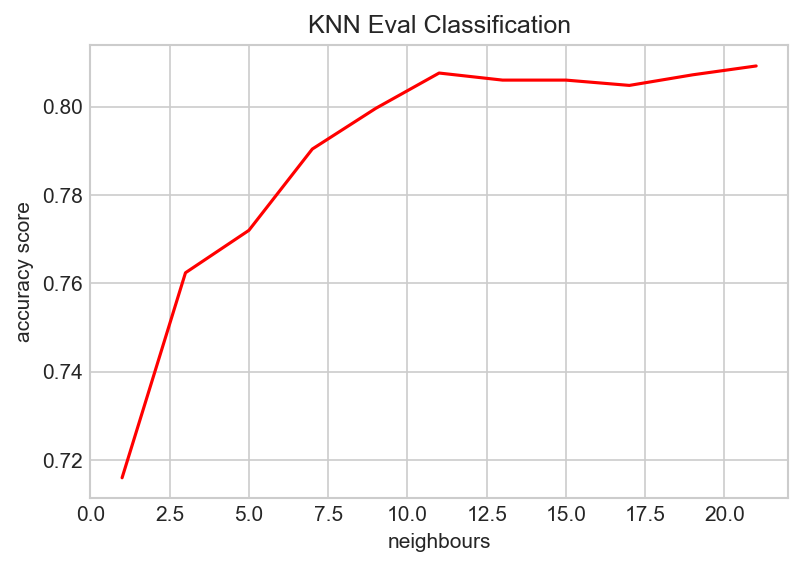

In [16]:
# Functiong plot from the beggining of the notebook
plot_(n_neigh, acc_list, 'neighbours', 'accuracy score', 'KNN Eval Classification')

### An logarithmic increase, the optimal number would be 11 neighbours. After that, it might just overfit.

# DTC heatmaps

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def  DTC(criterion_): 
    # Definind max_feature values (actually till len(X.columns) )
    feat = [1,2,3,4] 
    # Defining max_depth values
    dep = [3, 7,12,15,20,30]  
    # Creating an empty matrix
    a = np.empty([len(feat),len(dep)])  

    # Training the model and storing the MSE in the matrix
    for i in range(len(feat)):
        for j in range(len(dep)):
            classificator = DecisionTreeClassifier(random_state = 0, max_depth = dep[j] , max_features = feat[i], criterion = criterion_ )             
            classificator.fit(X_train, y_train)  
            y_pred = classificator.predict(X_test)    
            a[i][j]  = accuracy_score(y_test,y_pred)  
            
    # Plotting the heatmap
    ax = sns.heatmap(a, annot=True, xticklabels=dep,   yticklabels= feat)  

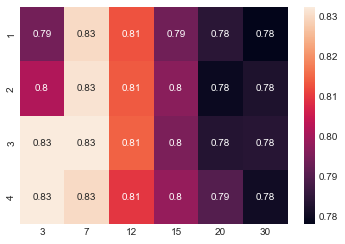

In [18]:
DTC('gini')

### Impressive that just for 1 feature and depth tree of 7 would give the same accuracy as using more features.

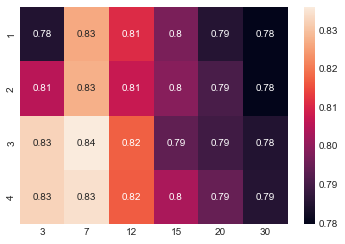

In [19]:
DTC('entropy')

### We got a 0.1 better precission on using 3 features and a depth of 7.

# RFC

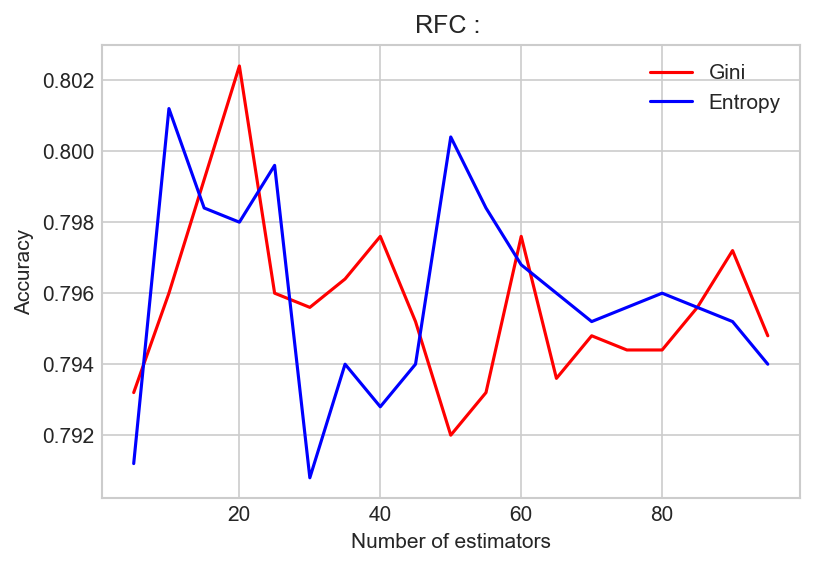

In [20]:
from sklearn.ensemble import RandomForestClassifier 

# Declaring necessary lists
n_est = list()

for i in range(5,100,5):
    n_est.append(i)

crit_list = ['gini', 'entropy'] 
final_acc= list()

# For each criterion type
for cr in crit_list:
    
    # Adds the acc Array
    acc_ = list() 
    
    # for different C values
    for i in range(len(n_est)):
            classificator = RandomForestClassifier(criterion = cr,n_estimators = n_est[i] )
            classificator.fit(X_train, y_train.values.ravel())  
            y_pred = classificator.predict(X_test)   
            acc_.append ( accuracy_score(y_test,y_pred))  
            
    final_acc.append(acc_) 

plt.style.use('seaborn-whitegrid')
fig = plt.figure(dpi = 150)
ax = plt.axes() 
plt.plot(n_est, final_acc[0], color = 'red', label = 'Gini' ) 
plt.plot(n_est, final_acc[1], color = 'blue', label = 'Entropy') 

plt.title('RFC : ')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy') 
plt.legend()

###  In this case, as the precision slightly differs, gini y is better as compared to entropy for accuracy of the model.

# SVC

In [21]:
from sklearn.svm import SVC 

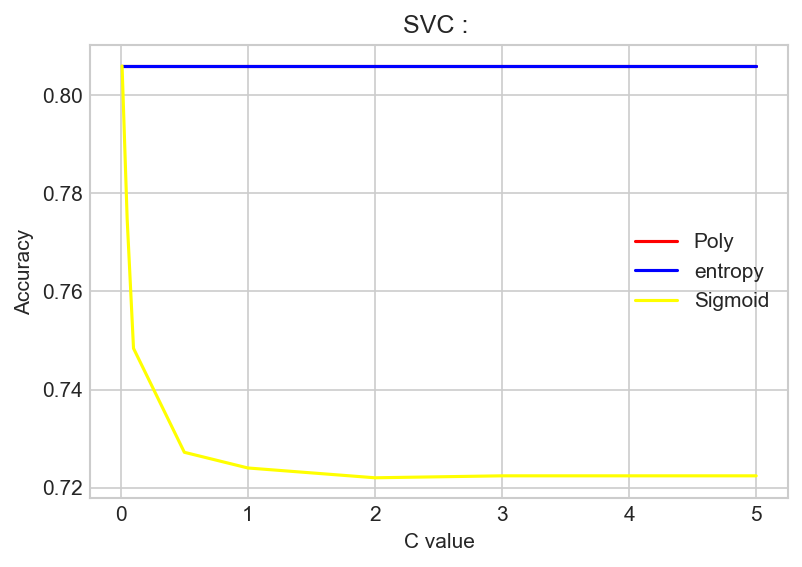

In [22]:
# Declaring necessary lists
C_list = [ 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 3.0,5.0 ]


ker_list = ['poly', 'rbf', 'sigmoid'] 
final_acc = list()

# For each kernel type
for ker in ker_list:
    
    # Adds the MSE Array
    acc_list = list() 
    
    # for different C values
    for i in range(len(C_list)):
            classificator = SVC(kernel = ker, C = C_list[i] )
            classificator.fit(X_train, y_train.values.ravel())  
            y_pred = classificator.predict(X_test)   
            acc_list.append ( accuracy_score(y_pred,y_test) )  
            
    final_acc.append(acc_list) 

plt.style.use('seaborn-whitegrid')
fig = plt.figure(dpi = 150)
ax = plt.axes() 
plt.plot(C_list, final_acc[0], color = 'red', label = 'Poly' ) 
plt.plot(C_list, final_acc[1], color = 'blue', label = 'entropy') 
plt.plot(C_list, final_acc[2], color = 'yellow', label = 'Sigmoid')
plt.title('SVC : ')
plt.xlabel('C value')
plt.ylabel('Accuracy') 
plt.legend()

# Basically Entropy and Poly kernels maintains the same score, an optimal one, for the mode while the Sigmoid decreases with the increase of regularization .